# Ejercicio Regression Tree
Son datos de temperaturas tomados de la ciudad de Seattle. El objetivo es intentar predecir lo mejor posible la máxima temperatura (columna `actual`) que alcanzaremos al día siguiente. Para ello contaremos con temperaturas de los dos días anteriores, históricos de máximas temperaturas y un amigo bastante chapas que te da su predicción del tiempo cada día.

**Resumen de datos**:
* *year*: 2016 para todos los registros.
* *month*: número del mes del año.
* *day*: número del día del año.
* *week*: día de la semana (cadena de caracteres).
* *temp_2*: temperatura máxima 2 días antes.
* *temp_1*: temperatura máxima 1 día antes.
* *average*: medición de temperatura máxima media histórica.
* *actual*: medición d ela temperatura máxima.
* *friend*: la predicción de tu amigo, un número aleatorio entre 20 por debajo del promedio y 20 por encima del promedio (*average* $\pm$ 20).


### 1. Importa el csv "temps.csv"

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import plot_tree, DecisionTreeRegressor, DecisionTreeClassifier

In [4]:
df=pd.read_csv('./data/temps.csv')

### 2. Trabaja las variables categóricas del dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            348 non-null    int64  
 1   month           348 non-null    int64  
 2   day             348 non-null    int64  
 3   week            348 non-null    object 
 4   temp_2          348 non-null    int64  
 5   temp_1          348 non-null    int64  
 6   average         348 non-null    float64
 7   actual          348 non-null    int64  
 8   forecast_noaa   348 non-null    int64  
 9   forecast_acc    348 non-null    int64  
 10  forecast_under  348 non-null    int64  
 11  friend          348 non-null    int64  
dtypes: float64(1), int64(10), object(1)
memory usage: 32.8+ KB


In [10]:
df.describe(include='all')

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
count,348.0,348.000000,348.000000,348,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
unique,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,Tues,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2016.0,6.477011,15.514368,NaN,62.652299,62.701149,59.760632,62.543103,57.238506,62.373563,59.772989,60.034483
std,0.0,3.498380,8.772982,NaN,12.165398,12.120542,10.527306,11.794146,10.605746,10.549381,10.705256,15.626179
min,2016.0,1.000000,1.000000,NaN,35.000000,35.000000,45.100000,35.000000,41.000000,46.000000,44.000000,28.000000
25%,2016.0,3.000000,8.000000,NaN,54.000000,54.000000,49.975000,54.000000,48.000000,53.000000,50.000000,47.750000
50%,2016.0,6.000000,15.000000,NaN,62.500000,62.500000,58.200000,62.500000,56.000000,61.000000,58.000000,60.000000
75%,2016.0,10.000000,23.000000,NaN,71.000000,71.000000,69.025000,71.000000,66.000000,72.000000,69.000000,71.000000


In [11]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

df['week_int']=le.fit_transform(df['week'])
df.head()

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_int
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29,0
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61,2
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56,3
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53,1
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41,5


Estaciones temporales:

In [12]:
df['autumn'] = np.where(df['month'].isin([10,11,12]), 1, 0)
df['winter'] = np.where(df['month'].isin([1,2,3]), 1, 0)
df['spring'] = np.where(df['month'].isin([4,5,6]), 1, 0)
df['sunmer'] = np.where(df['month'].isin([7,8,9]), 1, 0)

my_week = {10:1, 11:1, 12:1, 1:2, 2:2, 3:2, 4:3, 5:3, 6:3, 7:4, 8:4, 9:4}
df['season_int'] = df['month'].replace(my_week)

Variable objetivo: columna actual

In [6]:
df.columns

Index(['year', 'month', 'day', 'week', 'temp_2', 'temp_1', 'average', 'actual',
       'forecast_noaa', 'forecast_acc', 'forecast_under', 'friend'],
      dtype='object')

In [7]:
df.head()


,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


<Figure size 1200x1200 with 0 Axes>

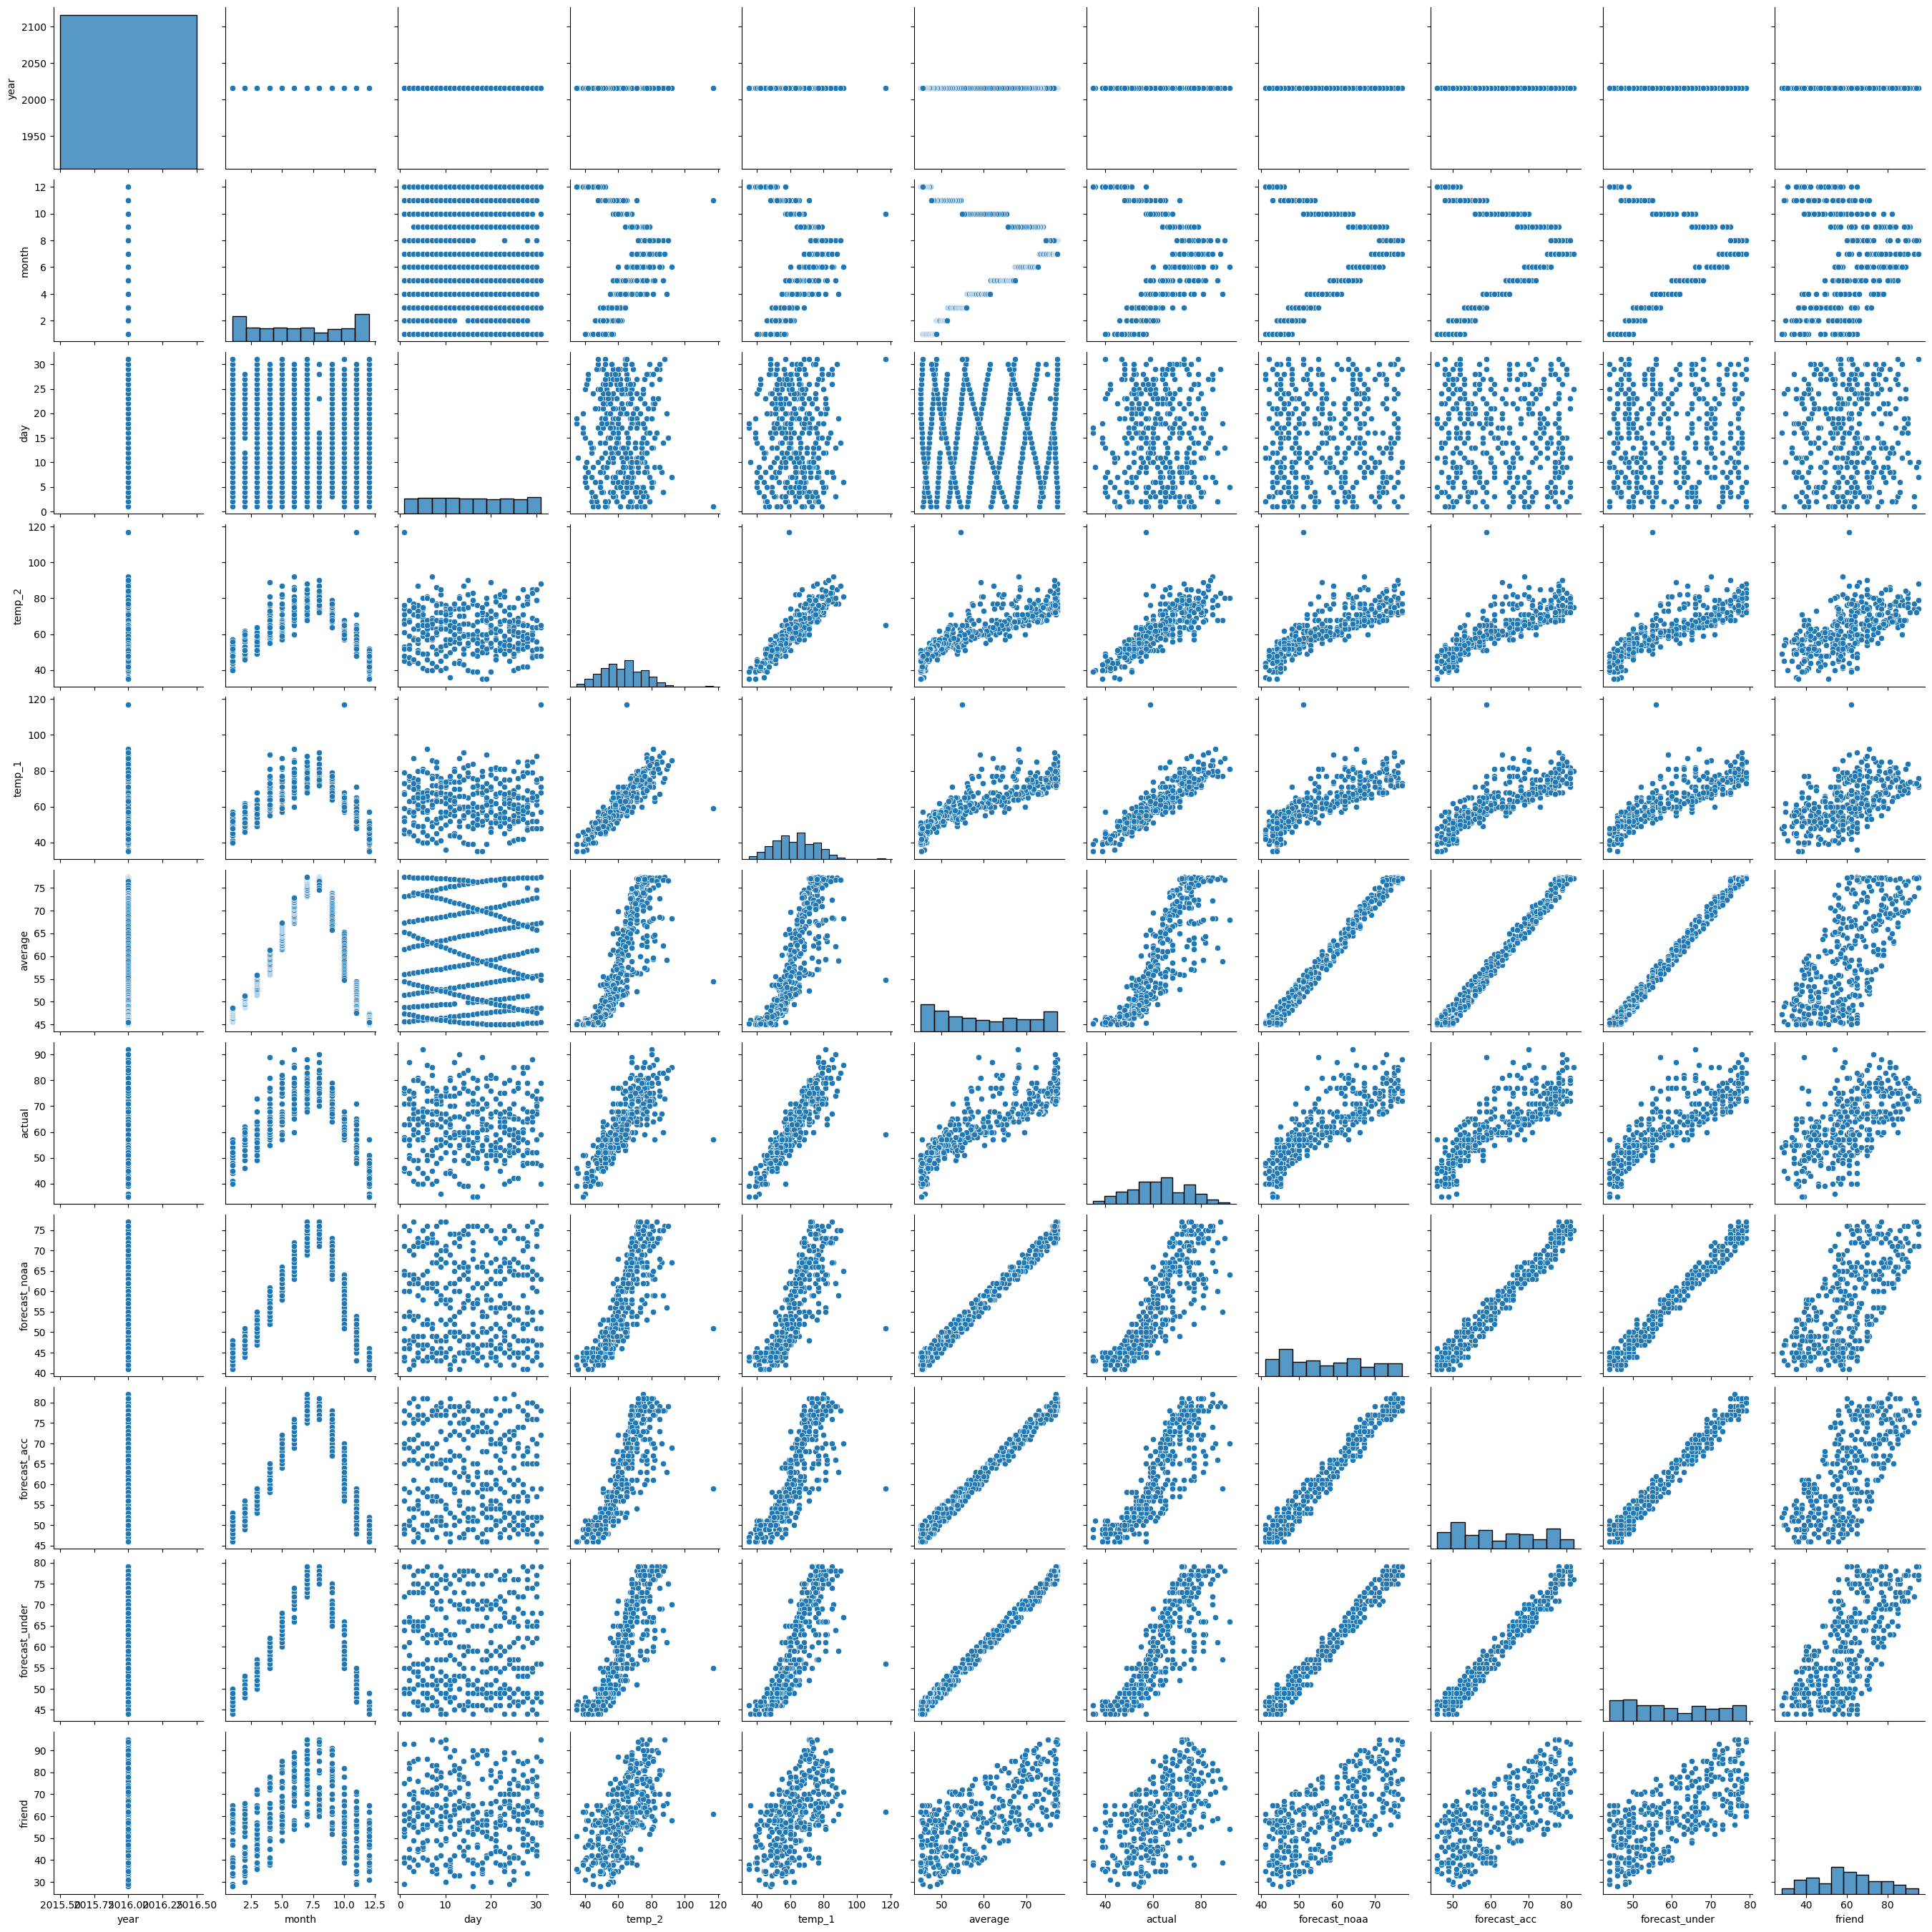

In [15]:
sns.pairplot(df);

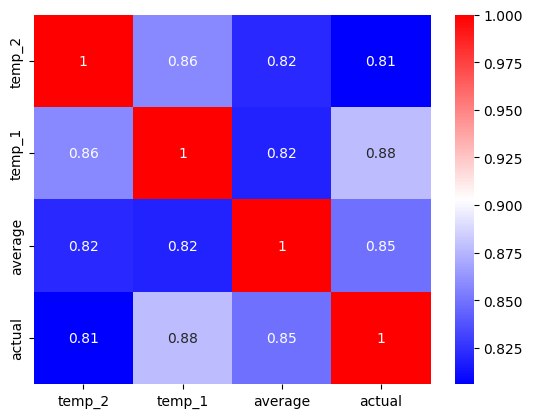

In [14]:
sns.heatmap(df[['temp_2', 'temp_1', 'average', 'actual']].corr(),
            cmap='bwr',
            annot=True);

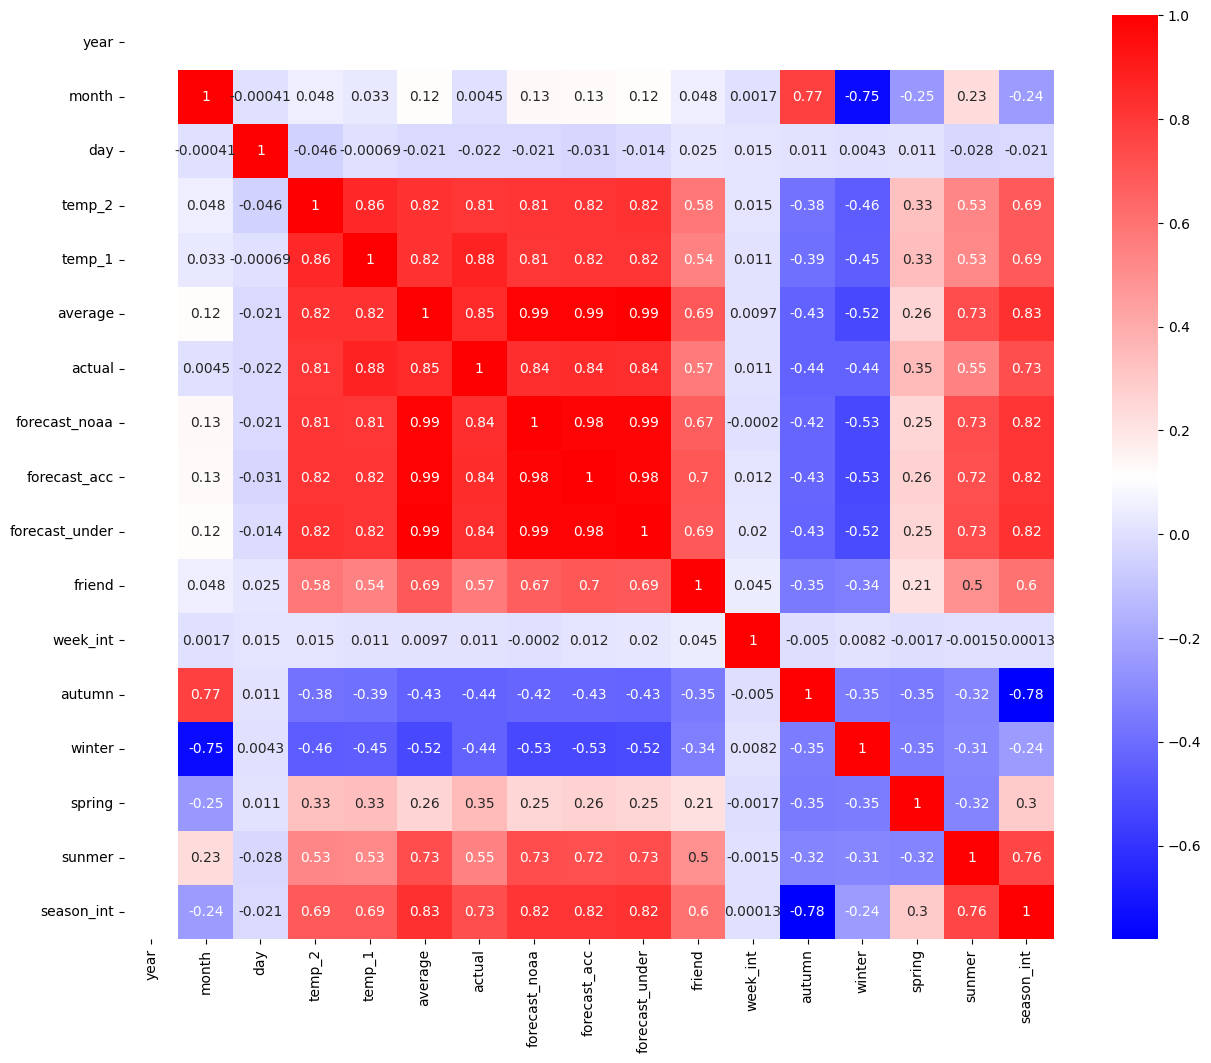

In [17]:
plt.figure(figsize=(15,12))

sns.heatmap(df.corr(numeric_only=True),
            cmap='bwr',
            annot=True);

### 3. Divide en train y test

In [20]:
#X=df[['month','day','temp_1','temp_2','average']]
X=df[['temp_1','average', 'forecast_noaa','season_int']]
y=df['actual']

x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=22)

### 4. Entrena el modelo


In [28]:
tree_reg=DecisionTreeRegressor(#max_depth=2,
                           random_state=22)
tree_reg.fit(x_train,y_train)

#Predicciones
y_pred = tree_reg.predict(x_test)

### 5. Evaluación de tu modelo
Calcula el coeficiente de determinación. 

Calcula el MAE, MAPE, MSE y RMSE.

In [29]:
#Coeficiente de determinación
tree_reg.score(x_train,y_train)


1.0

In [31]:
print('MAE test:', metrics.mean_absolute_error(y_test, y_pred)) #media de los errores en valor absoluto
print('MAPE test:', metrics.mean_absolute_percentage_error(y_test, y_pred))  
print("MSE test", metrics.mean_squared_error(y_test, y_pred))
print("RMSE test", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("r2: ", metrics.r2_score(y_test,y_pred))
print('-'*100)

train_pred=tree_reg.predict(x_train)
print('MAE train:', metrics.mean_absolute_error(y_train, train_pred)) 
print('MAPE train:', metrics.mean_absolute_percentage_error(y_train, train_pred))
print("MSE train", metrics.mean_squared_error(y_train, train_pred))
print("RMSE train", np.sqrt(metrics.mean_squared_error(y_train, train_pred)))

MAE test: 5.3428571428571425
MAPE test: 0.09117389846757233
MSE test 40.08571428571429
RMSE test 6.331328003327129
r2:  0.7615567641060503
----------------------------------------------------------------------------------------------------
MAE train: 0.0
MAPE train: 0.0
MSE train 0.0
RMSE train 0.0


### 6. Representa el árbol de decision

SOBREAJUSTE!

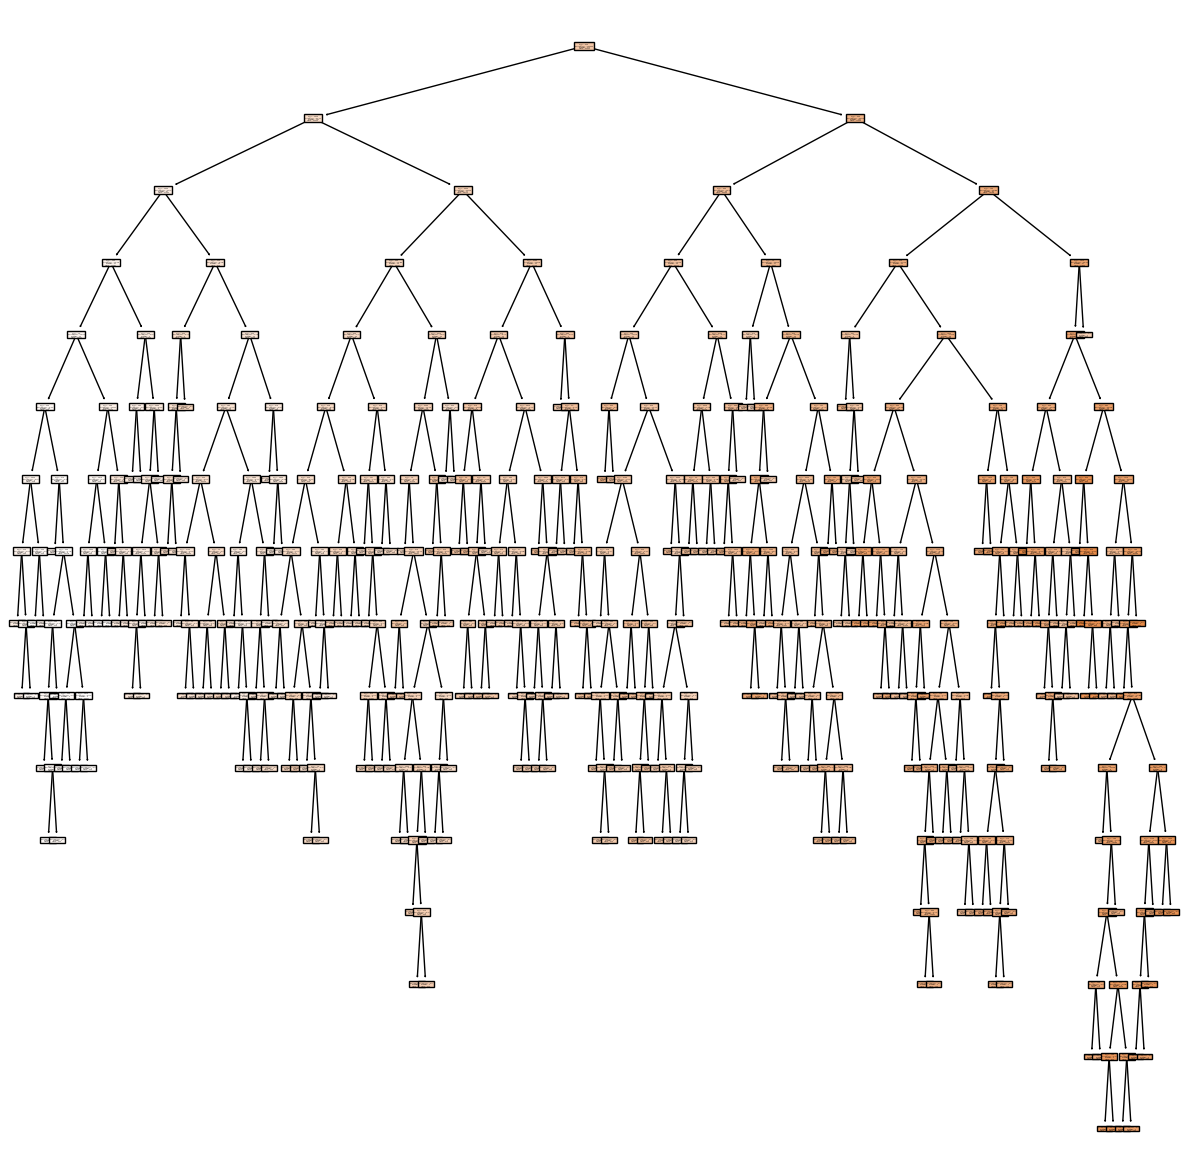

In [33]:
plt.figure(figsize=(15,15))
plot_tree(tree_reg,
            feature_names=x_train.columns,
          filled=True);

### 7. Modifica el max_depth a 3 y vuelve a entrenarlo

In [35]:
tree_reg=DecisionTreeRegressor(max_depth=3,
                           random_state=22)
tree_reg.fit(x_train,y_train)

#Predicciones
y_pred = tree_reg.predict(x_test)

### 8. Vuelve a evaluar tu modelo

In [36]:
#Coeficiente de determinación
tree_reg.score(x_train,y_train)

0.8327314891525934

In [39]:
print('MAE test:', metrics.mean_absolute_error(y_test, y_pred)) #media de los errores en valor absoluto
print('MAPE test:', metrics.mean_absolute_percentage_error(y_test, y_pred))  
print("MSE test", metrics.mean_squared_error(y_test, y_pred))
print("RMSE test", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2 test: ", metrics.r2_score(y_test,y_pred))

print('-'*100)

train_pred=tree_reg.predict(x_train)
print('MAE train:', metrics.mean_absolute_error(y_train, train_pred)) 
print('MAPE train:', metrics.mean_absolute_percentage_error(y_train, train_pred))
print("MSE train", metrics.mean_squared_error(y_train, train_pred))
print("RMSE train", np.sqrt(metrics.mean_squared_error(y_train, train_pred)))
print('R2 train', tree_reg.score(x_train,y_train))

MAE test: 4.068825262998651
MAPE test: 0.07062836716480747
MSE test 25.55745893723
RMSE test 5.05543855043556
R2 test:  0.8479756861313648
----------------------------------------------------------------------------------------------------
MAE train: 3.642033111905761
MAPE train: 0.05799257520810501
MSE train 21.836182934514188
RMSE train 4.672920172067375
R2 train 0.8327314891525934


### 9. Vuelve a representar su árbol

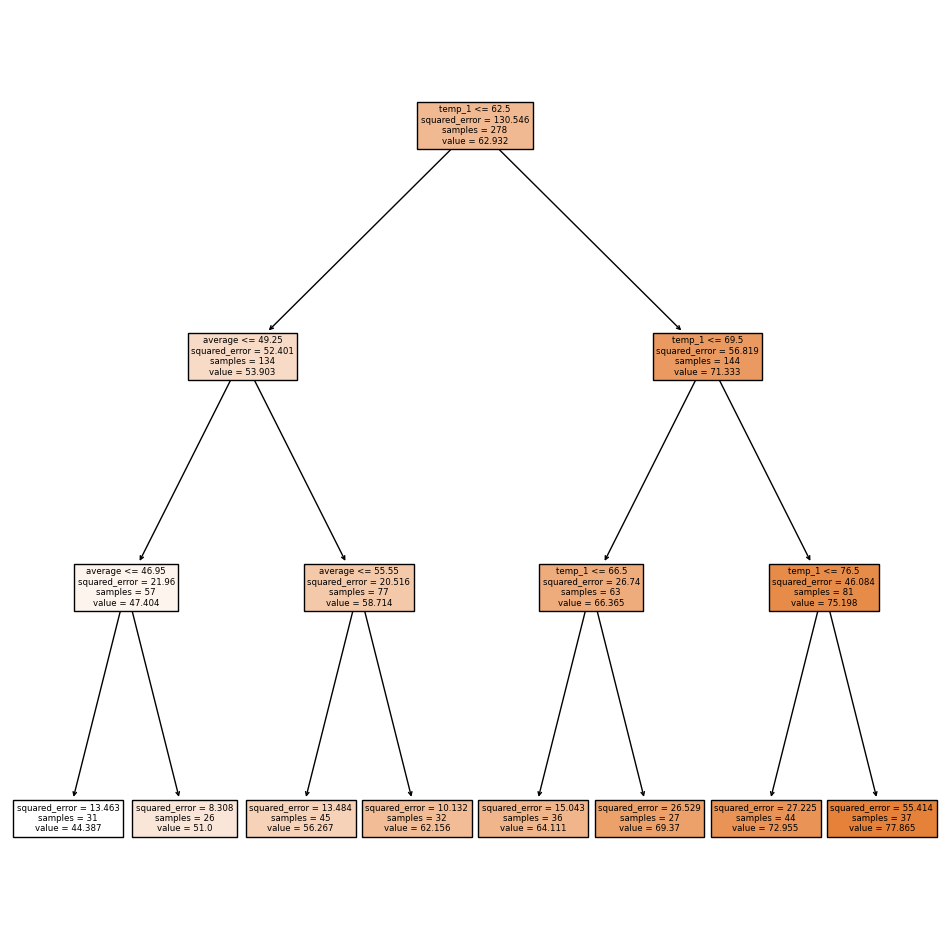

In [41]:
plt.figure(figsize=(12,12))
plot_tree(tree_reg,
          feature_names=x_train.columns,
          filled=True);

### 10. Utiliza un grid search con cross validation.

In [43]:
#Arbol de regresión
tree_reg=DecisionTreeRegressor(random_state=22)

#Parametros que deseamos explorar
parametros = {
    'max_depth': [2,3,4,5,6], #Profundidades maximas del arbol
    'criterion': ['squared_error', 'absolute_error'],
    'min_samples_split': [2, 5, 10], #número mínimo de muestras para dividir un nodo interno
    'min_samples_leaf': [1, 2, 4], # número mínimo de muestras para estar en un nodo hoja
    'max_features':  [1,2,3,4]

}

#Creamos el objeto Gridsearch con validación cruzada
gridsearch=GridSearchCV(tree_reg,parametros, cv=5, scoring='neg_mean_squared_error')

#Entrenamiento
gridsearch.fit(x_train,y_train)


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=22),
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [2, 3, 4, 5, 6],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error')

In [45]:
#Obtenemos el mejor modelo y los mejores parametros
best_tree_reg=gridsearch.best_estimator_
best_params=gridsearch.best_params_
print("Mejores parámetros:", best_params)

#Predicciones con el mejor modelo
y_pred=best_tree_reg.predict(x_test)

Mejores parámetros: {'criterion': 'squared_error', 'max_depth': 4, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [48]:
gridsearch.best_score_

-24.61195172229167

Valoración del mejor modelo:

In [47]:
print('MAE test:', metrics.mean_absolute_error(y_test, y_pred)) #media de los errores en valor absoluto
print('MAPE test:', metrics.mean_absolute_percentage_error(y_test, y_pred))  
print("MSE test", metrics.mean_squared_error(y_test, y_pred))
print("RMSE test", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('-'*100)

train_pred=best_tree_reg.predict(x_train)
print('MAE train:', metrics.mean_absolute_error(y_train, train_pred)) 
print('MAPE train:', metrics.mean_absolute_percentage_error(y_train, train_pred))
print("MSE train", metrics.mean_squared_error(y_train, train_pred))
print("RMSE train", np.sqrt(metrics.mean_squared_error(y_train, train_pred)))

MAE test: 4.177514715642861
MAPE test: 0.07154502186233694
MSE test 25.950781401975892
RMSE test 5.094190946752574
----------------------------------------------------------------------------------------------------
MAE train: 3.1895555791688683
MAPE train: 0.050776188856964166
MSE train 17.153927237240786
RMSE train 4.141729981208431


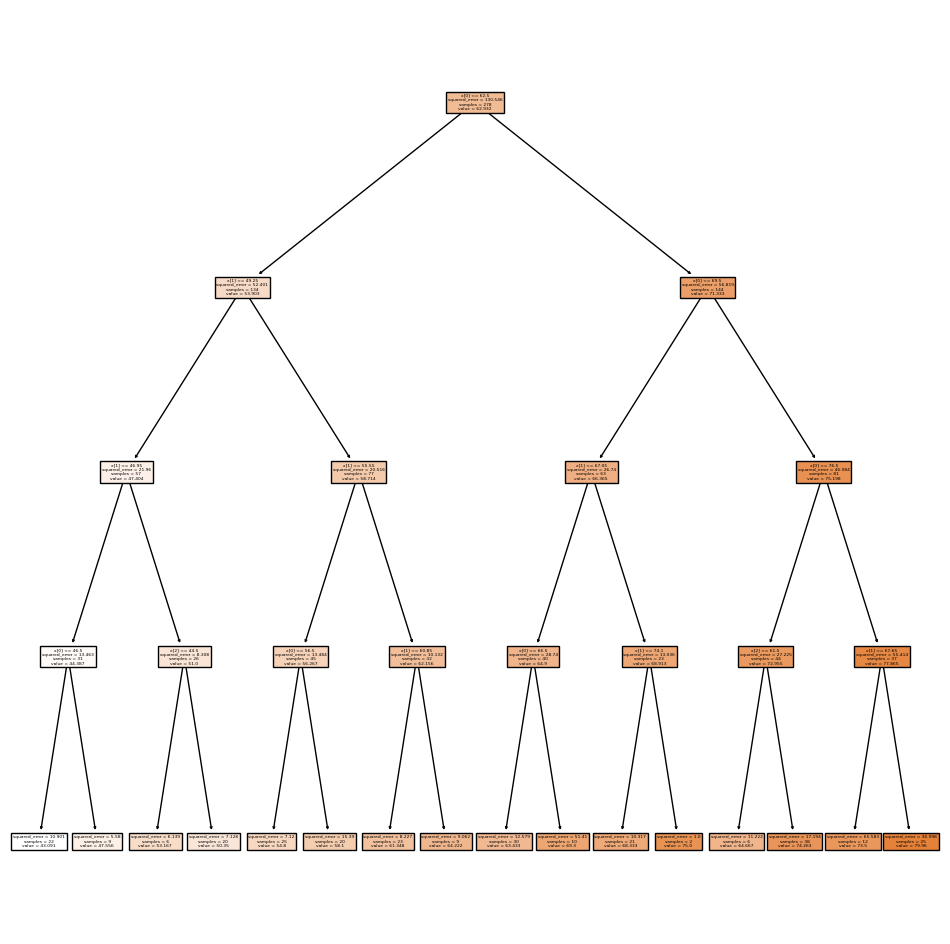

In [49]:
plt.figure(figsize=(12,12))
plot_tree(best_tree_reg,
          filled=True);

### 11. Obten el `feature_importances` de cada variable en el último modelo

In [52]:
feature_importance=best_tree_reg.feature_importances_

#Creamos un Dataframe con las importancias de cada caracteristicas
df_carac=pd.DataFrame({'Feature':x_train.columns,'Importance': feature_importance})
df_carac=df_carac.sort_values(by='Importance',ascending=False)
df_carac

,Feature,Importance
0,temp_1,0.788112
1,average,0.195588
2,forecast_noaa,0.016300
3,season_int,0.000000


### 12. Construye un nuevo modelo `DecisionTreeClassifier` que te clasifique cuando en un día va a hacer una temperatura mayor a 15ºC. ¡Deberá tratarse como un problema de **clasificación**! Utiliza un grid search con cross validation y evalúa el mejor modelo.

In [53]:
df.actual.unique()

array([45, 44, 41, 40, 51, 48, 50, 52, 49, 55, 54, 57, 56, 47, 46, 53, 62,
       58, 60, 59, 61, 64, 63, 68, 73, 71, 69, 77, 76, 66, 89, 81, 65, 87,
       74, 82, 67, 75, 79, 80, 92, 86, 85, 70, 78, 72, 83, 88, 90, 84, 42,
       36, 43, 39, 35], dtype=int64)

Como vemos los datos no vienen en unidades de Gados Celcius, °C. Vienen en  Fahrenheit, °F,  (unidad de medida de Seatle). 15 °C equivalen a 59 °F.

In [54]:
#Input: grados en centigrados. Output: su equivalencia en Fahrenheit.
def conversion_grados(centigrado):
    return (centigrado*9/5)+32

print(conversion_grados(15))

59.0


Creamos una nueva columna en el dataframe. 
- 0: actual < 59F (no va a hacer mas de 15 grados centigrados)
- 1: actual > 59 F (si va a hacer mas que 15 grados centigrados)

In [67]:
df.head(2)

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61


In [55]:
df['> 15 °C']=[0 if i==False else 1 for i in df.actual>59]
df.head(2)

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_int,autumn,winter,spring,sunmer,season_int,> 15 °C
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29,0,0,1,0,0,2,0
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61,2,0,1,0,0,2,0


<Axes: >

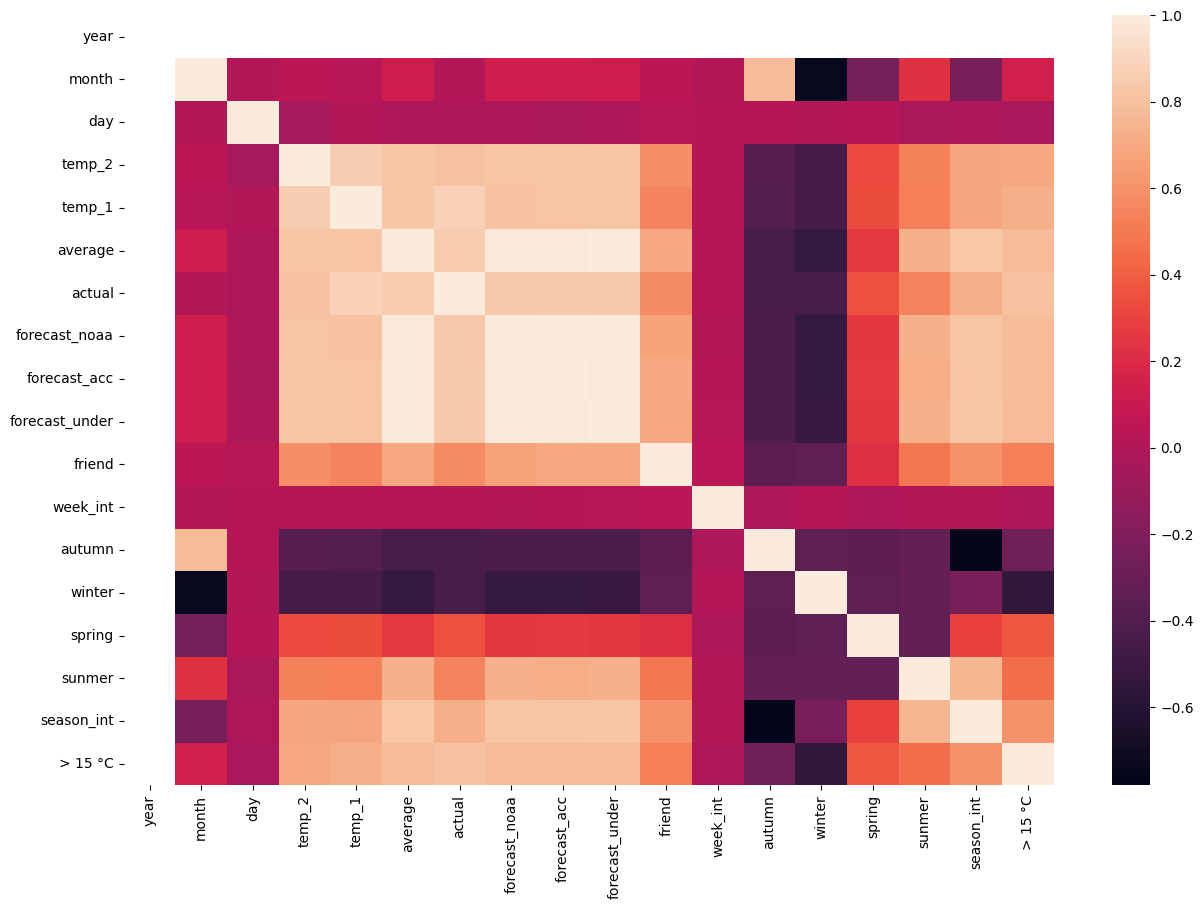

In [56]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(numeric_only=True))

In [62]:
#Division de los datos
X=df[['temp_1','average','season_int']]
y=df['> 15 °C']
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=22)

#Arbol de clasificación
tree_clasi=DecisionTreeClassifier(random_state=2024)

#Parametros que deseamos explorar
parametros = {
    'max_depth': [2,3,4,5,6,8], #Profundidades maximas del arbol
    'min_samples_split': [2, 5, 10], #número mínimo de muestras para dividir un nodo interno
    'min_samples_leaf': [1, 2, 4] # número mínimo de muestras para estar en un nodo hoja
}

#Creamos el objeto Gridsearch con validación cruzada
gridsearch=GridSearchCV(tree_clasi,parametros, cv=5, scoring='accuracy')

#Entrenamiento
gridsearch.fit(x_train,y_train)

#Obtenemos el mejor modelo y los mejores parametros
best_tree_clasi=gridsearch.best_estimator_
best_params=gridsearch.best_params_
print("Mejores parámetros:", best_params)

#Predicciones con el mejor modelo
y_pred=best_tree_clasi.predict(x_test)

Mejores parámetros: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [61]:
print('Accuracy train: ', best_tree_clasi.score(x_train, y_train))
print('Accuracy test: ', metrics.accuracy_score(y_test, y_pred))

Accuracy train:  0.935251798561151
Accuracy test:  0.8857142857142857


In [60]:
metrics.confusion_matrix(y_test,y_pred)

array([[31,  8],
       [ 0, 31]], dtype=int64)

In [ ]:
metrics.roc_auc_score(y_test,y_pred)

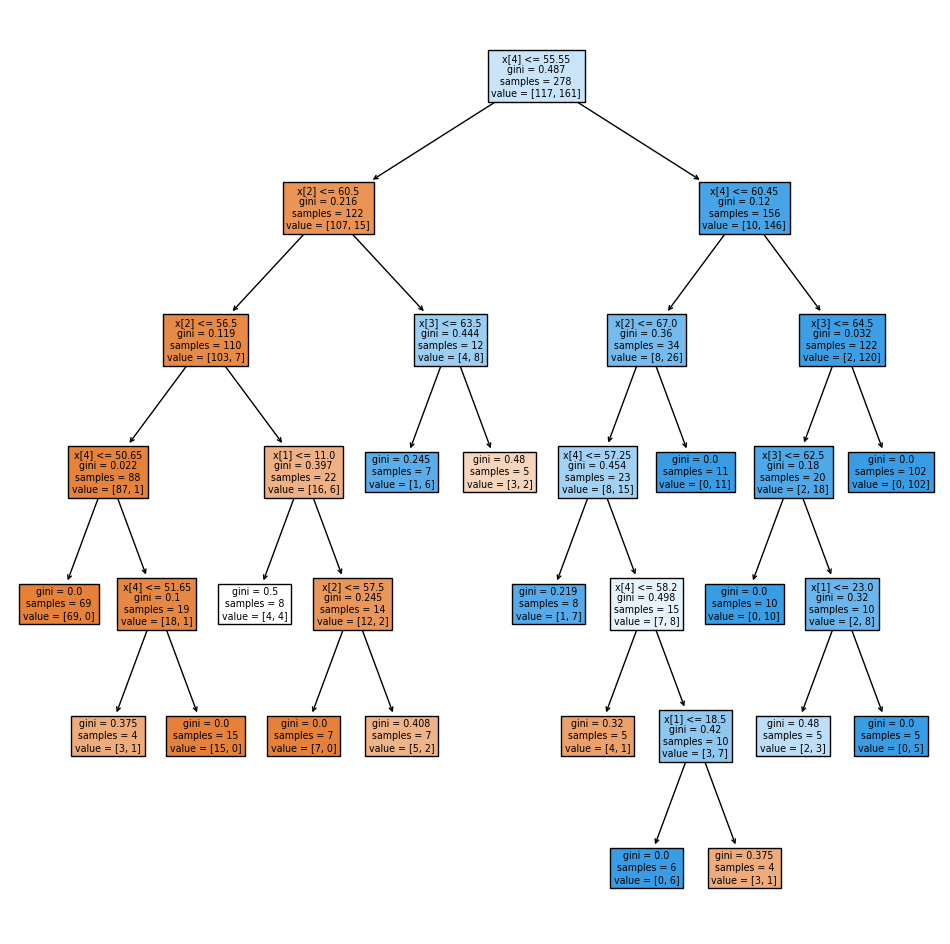

In [81]:
plt.figure(figsize=(12,12))
plot_tree(best_tree_reg,
          filled=True);

### 13. Construye un nuevo modelo `RandomForestClassifier` que te clasifique cuando en un día va a hacer una temperatura mayor a 15ºC. ¡Deberá tratarse como un problema de **clasificación**! Utiliza un grid search con cross validation y evalúa el mejor modelo.

In [64]:
from sklearn.ensemble import RandomForestClassifier


In [66]:
#Division de los datos
X=df[['month','day','temp_1','temp_2','average']]
y=df['> 15 °C']
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=22)

#Arbol de clasificación
rf_clasi=RandomForestClassifier(random_state=2024)

#Parametros que deseamos explorar
parametros = {
    'n_estimators': [50, 100,200],  # Número de árboles en el bosque: PONER MENOS SE VUELVE LOCO EL ORDENADOR
    'max_depth': [2,3,4,5,6,8], #Profundidades maximas del arbol
    'min_samples_split': [2, 5, 10], #número mínimo de muestras para dividir un nodo interno
    'min_samples_leaf': [1, 2, 4] # número mínimo de muestras para estar en un nodo hoja
}

#Creamos el objeto Gridsearch con validación cruzada
gridsearch=GridSearchCV(rf_clasi,parametros, cv=5, scoring='accuracy')

#Entrenamiento
gridsearch.fit(x_train,y_train)

#Obtenemos el mejor modelo y los mejores parametros
best_rf_clasi=gridsearch.best_estimator_
best_params=gridsearch.best_params_
print("Mejores parámetros:", best_params)

#Predicciones con el mejor modelo
y_pred=best_rf_clasi.predict(x_test)

Mejores parámetros: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}


In [67]:
gridsearch.best_score_

0.9245454545454546